16008450 Inés Alarcón

## Laboratorio #4: Machine Learning para Regresiones

Para el dataset walmart.csv adjunto a este laboratorio deberá desarrollar y encontrar un
modelo de regresión que funcione lo mejor posible, tome en cuenta el siguiente flujo de
trabajo para resolver el problema.

#### EDA – Exploratory Data Analysis: Luego de cargar el dataset proporcionado deberá
realizar una análisis exploratorio de las variables disponibles en el dataset
considerando lo siguiente pasos:

Gráficas de Densidad – Deberá realizar una gráfica de densidad de cada variable continua del dataset (Weekly_Sales, Temperature, Fue_Price, CPI, Unenployment) haciendo un comentario general sobre su opinión al respecto del resultado.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

df = pd.read_csv('walmart.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None


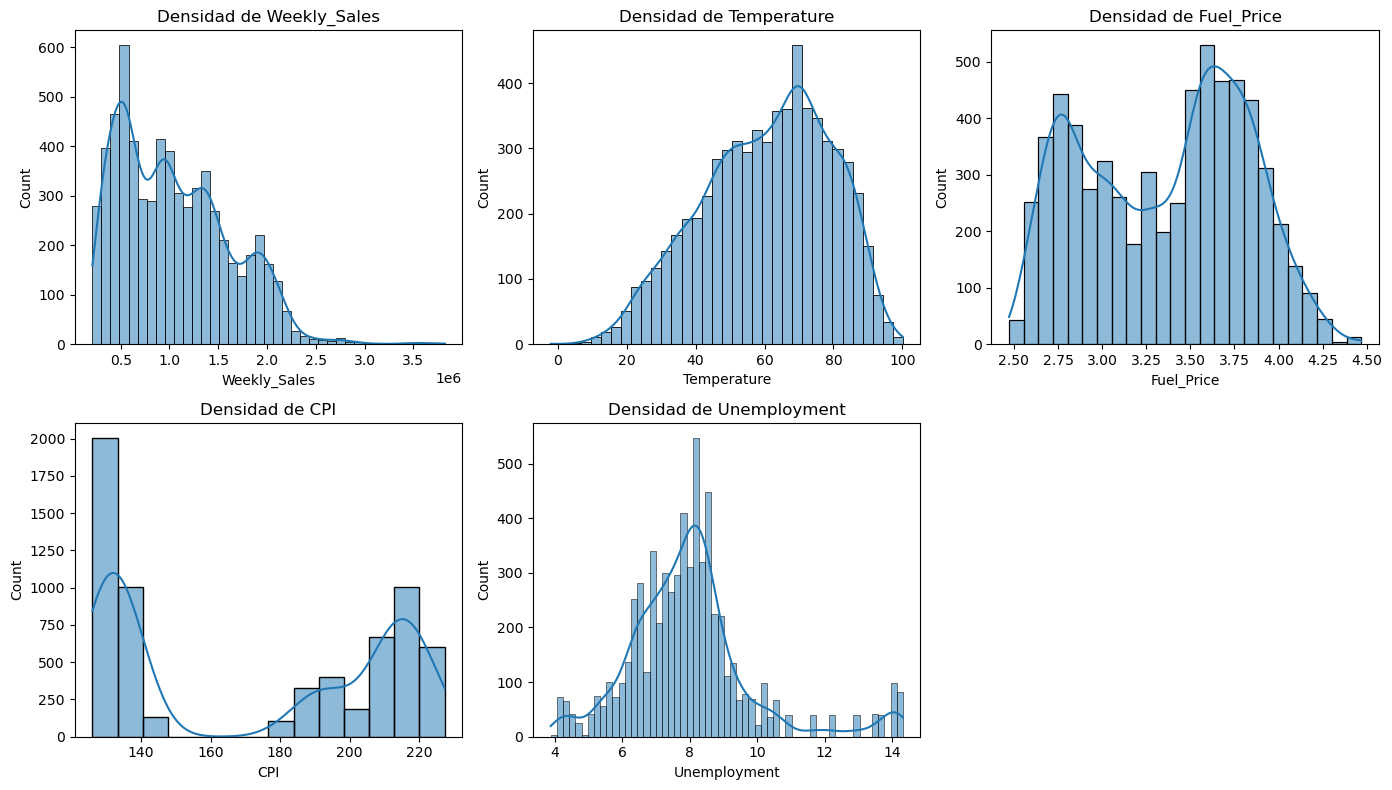

In [84]:
continuous_vars = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.figure(figsize=(14, 8))

for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Densidad de {col}')

plt.tight_layout()
plt.show()

-> Weekly_Sales: La distribución de las ventas semanales parece sesgada hacia la derecha, lo que sugiere que hay algunos valores altos de ventas.

-> Temperature: La temperatura parece seguir una distribución normal, con picos alrededor de ciertos rangos de temperatura.

-> Fuel_Price: El precio del combustible parece tener una distribución más uniforme, con algunos picos alrededor de ciertos valores.

-> CPI (Índice de Precios al Consumidor): La distribución del CPI también parece sesgada, mostrando una concentración alrededor de ciertos valores.

-> Unemployment (Tasa de Desempleo): La tasa de desempleo muestra una distribución con valores más altos hacia la izquierda y una cola larga hacia la derecha.

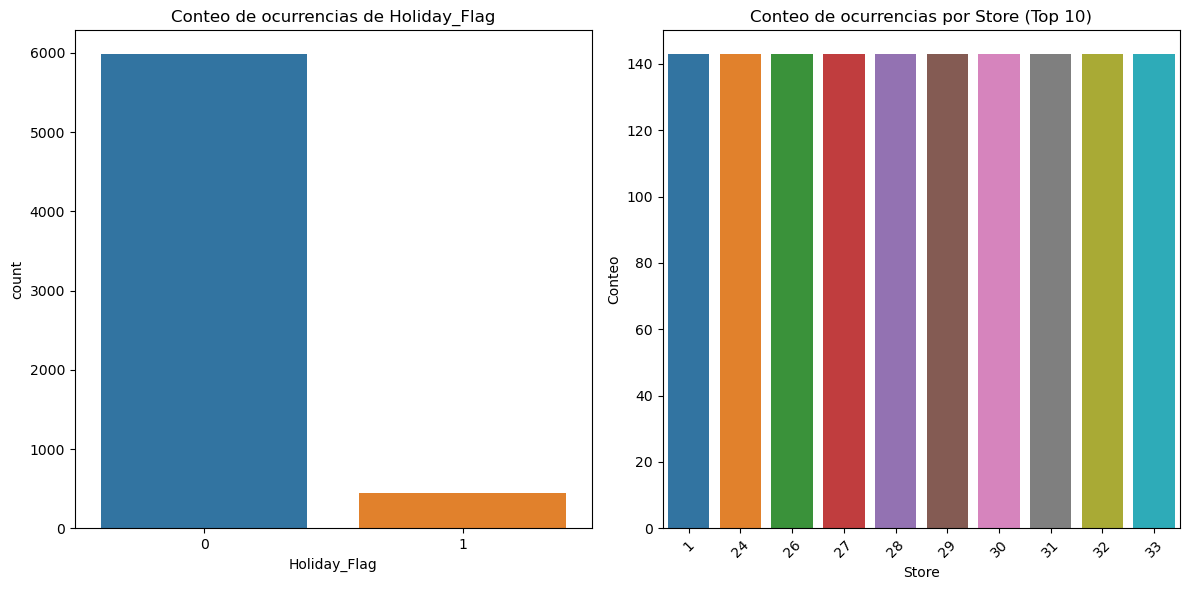

In [85]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Holiday_Flag', data=df)
plt.title('Conteo de ocurrencias de Holiday_Flag')

plt.subplot(1, 2, 2)
top_stores = df['Store'].value_counts().head(10)
sns.barplot(x=top_stores.index, y=top_stores.values)
plt.title('Conteo de ocurrencias por Store (Top 10)')
plt.xlabel('Store')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-> Holiday_Flag: La gráfica de barras muestra la distribución de días feriados (1) frente a no feriados (0). Esto nos ayuda a entender cuántos días de ventas corresponden a días feriados y cuántos a días normales en el dataset.

-> Store: La gráfica de barras para las tiendas (Store) nos muestra las tiendas con más ventas registradas en el dataset. Esto puede ser útil para identificar si algunas tiendas tienen una presencia más significativa en el dataset que otras.

In [86]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df = df.sort_values(by='Date')

print(df.head())

      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1287     10 2010-02-05    2193048.75             0        54.34       2.962   
5148     37 2010-02-05     536006.73             0        45.97       2.572   
2288     17 2010-02-05     789036.02             0        23.11       2.666   
4147     30 2010-02-05     465108.52             0        39.05       2.572   

             CPI  Unemployment  
0     211.096358         8.106  
1287  126.442065         9.765  
5148  209.852966         8.554  
2288  126.442065         6.548  
4147  210.752605         8.324  


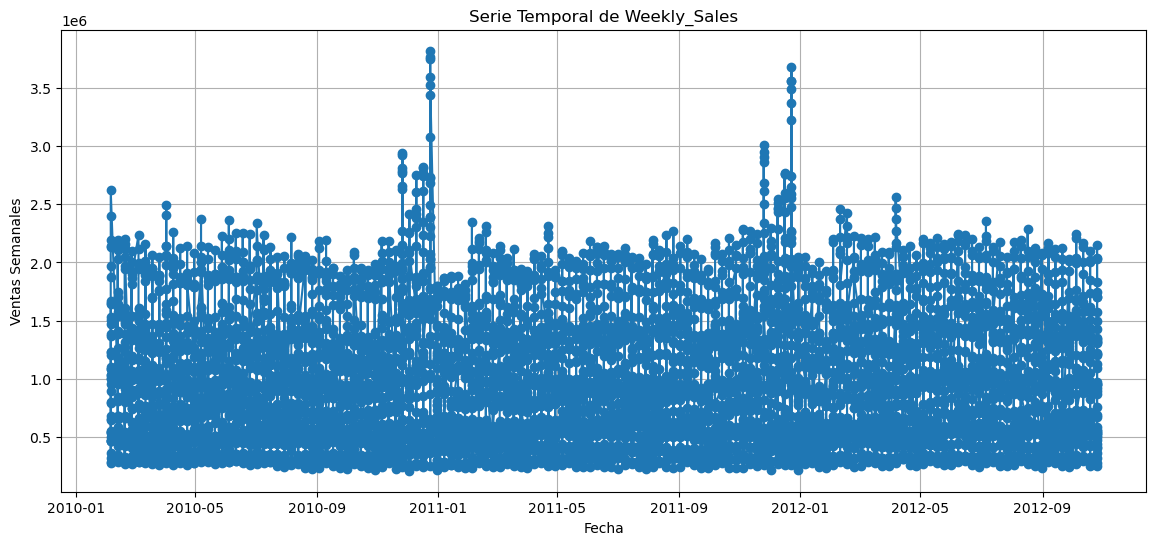

In [87]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Weekly_Sales'], marker='o', linestyle='-')
plt.title('Serie Temporal de Weekly_Sales')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.grid(True)
plt.show()

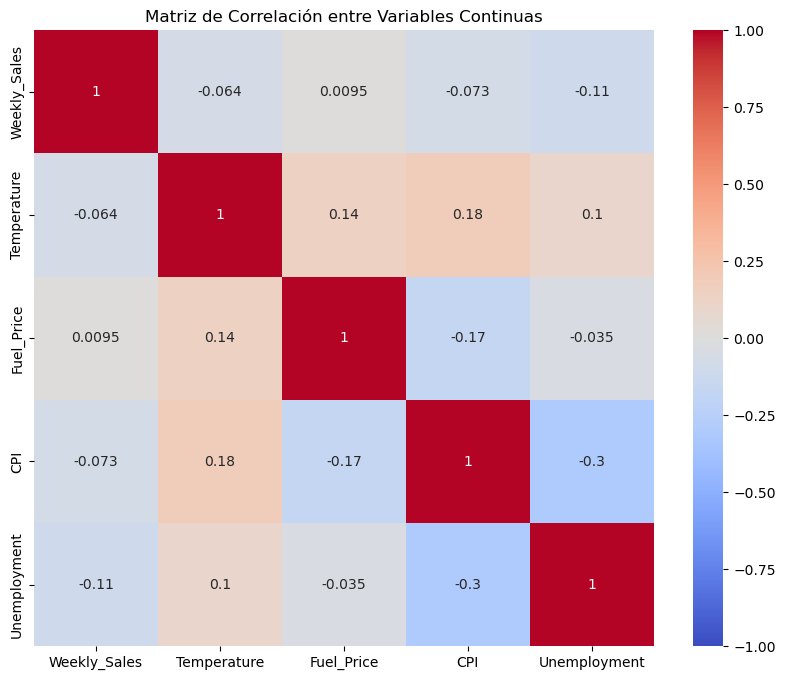

In [88]:
continuous_vars = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df_continuous = df[continuous_vars]

corr_matrix = df_continuous.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación entre Variables Continuas')
plt.show()

-> Se observa que las ventas semanales exhiben una distribución sesgada hacia la derecha con variabilidad significativa, posiblemente influenciada por factores estacionales, promocionales y eventos especiales. Las variables ambientales como temperatura y precio del combustible muestran patrones estacionales que podrían afectar las ventas, mientras que el CPI y la tasa de desempleo reflejan cambios en el poder adquisitivo del consumidor. Los días feriados pueden tener un impacto distintivo en las ventas debido a promociones específicas. La matriz de correlación revela relaciones moderadas entre estas variables, destacando la necesidad de considerar interacciones complejas al construir un modelo de regresión. Antes de avanzar, es crucial diseñar un modelo que capture adecuadamente estas dinámicas para predecir con precisión las ventas semanales en Walmart.

#### Modelos de Regresión 
Luego del EDA y considerando sus hallazgos, deberá desarrollar los siguientes pasos para implementar modelos de regresión:

In [89]:
X = df[['Temperature']]
y = df['Weekly_Sales']  

from sklearn.model_selection import train_test_split

# Dividir los datos en 80% entrenamiento y 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos creados
print("Dimensiones de los conjuntos:")
print("Conjunto de entrenamiento (X):", X_train.shape)
print("Conjunto de testing (X):", X_test.shape)
print("Conjunto de entrenamiento (y):", y_train.shape)
print("Conjunto de testing (y):", y_test.shape)

Dimensiones de los conjuntos:
Conjunto de entrenamiento (X): (5148, 1)
Conjunto de testing (X): (1287, 1)
Conjunto de entrenamiento (y): (5148,)
Conjunto de testing (y): (1287,)


In [90]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Modelo de Regresión Lineal:")
print("MSE (Mean Squared Error):", mse)
print("R2 Score:", r2)

Modelo de Regresión Lineal:
MSE (Mean Squared Error): 314197626268.74506
R2 Score: -0.00788529127275428


In [91]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['DayOfWeek'] = df['Date'].dt.dayofweek

df['IsWeekend'] = df['Date'].dt.weekday >= 5

print(df.head())

      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1287     10 2010-02-05    2193048.75             0        54.34       2.962   
5148     37 2010-02-05     536006.73             0        45.97       2.572   
2288     17 2010-02-05     789036.02             0        23.11       2.666   
4147     30 2010-02-05     465108.52             0        39.05       2.572   

             CPI  Unemployment  Year  Month  Day  DayOfWeek  IsWeekend  
0     211.096358         8.106  2010      2    5          4      False  
1287  126.442065         9.765  2010      2    5          4      False  
5148  209.852966         8.554  2010      2    5          4      False  
2288  126.442065         6.548  2010      2    5          4      False  
4147  210.752605         8.324  2010      2    5          4      False  


In [92]:
df = df.drop(columns=['Date'])

In [93]:
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
DayOfWeek       0
IsWeekend       0
dtype: int64


In [94]:
X = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag', 'DayOfWeek', 'IsWeekend']]
y = df['Weekly_Sales']
model = LinearRegression()

# Definir la estrategia de validación cruzada repetida
n_splits = 5  # Número de particiones en cada iteración
n_repeats = 3  # Número de repeticiones de la validación cruzada
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Realizar validación cruzada y registrar los resultados
scores = cross_val_score(model, X, y, cv=rkf, scoring='r2')

# Imprimir los resultados de la validación cruzada repetida
print(f'Resultados de Repeated Cross-Validation ({n_splits}-fold, {n_repeats} repeticiones):')
for i, score in enumerate(scores):
    print(f'Iteración {i+1}: R2 Score = {score:.4f}')

# Calcular y mostrar el promedio de los resultados
print(f'\nPromedio R2 Score: {np.mean(scores):.4f}')

Resultados de Repeated Cross-Validation (5-fold, 3 repeticiones):
Iteración 1: R2 Score = 0.0109
Iteración 2: R2 Score = 0.0296
Iteración 3: R2 Score = 0.0201
Iteración 4: R2 Score = 0.0160
Iteración 5: R2 Score = 0.0347
Iteración 6: R2 Score = 0.0217
Iteración 7: R2 Score = 0.0242
Iteración 8: R2 Score = 0.0182
Iteración 9: R2 Score = 0.0297
Iteración 10: R2 Score = 0.0209
Iteración 11: R2 Score = 0.0263
Iteración 12: R2 Score = 0.0152
Iteración 13: R2 Score = 0.0267
Iteración 14: R2 Score = 0.0291
Iteración 15: R2 Score = 0.0117

Promedio R2 Score: 0.0223


In [95]:
X = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag', 'DayOfWeek', 'IsWeekend']]
y = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")

Dimensiones de X_train: (5148, 7), X_test: (1287, 7)


In [96]:
models = {
    'Regresión Lineal': LinearRegression(),
    'SVR': SVR(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor()
}

params = {
    'Regresión Lineal': {},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]},
    'Árbol de Decisión': {'max_depth': [None, 10, 20, 30]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2]},
    'KNN': {'n_neighbors': [5, 10, 15]}
}

results = []
for name, model in models.items():
    print(f'Entrenando {name}...')
    grid_search = GridSearchCV(model, params[name], scoring='neg_root_mean_squared_error', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'Nombre del modelo': name,
        'Hyper-parámetros ganadores': grid_search.best_params_,
        'RMSE de registro': rmse,
        'Variables incluidas': list(X.columns),
        'Tag del modelo': 'Champion' if rmse < 1000 else 'Challenger' if rmse < 5000 else 'Deprecated'
    })
    
    print(f'{name}: RMSE = {rmse:.2f}')
    print(f'Mejores hiperparámetros: {grid_search.best_params_}\n')

results_sorted = sorted(results, key=lambda x: x['RMSE de registro'])

print("\nResultados ordenados por RMSE de registro:")
for idx, result in enumerate(results_sorted):
    print(f"{idx + 1}. Modelo: {result['Nombre del modelo']}, RMSE: {result['RMSE de registro']:.2f}")


Entrenando Regresión Lineal...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Regresión Lineal: RMSE = 555281.48
Mejores hiperparámetros: {}

Entrenando SVR...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVR: RMSE = 563710.77
Mejores hiperparámetros: {'C': 0.1, 'kernel': 'rbf'}

Entrenando Árbol de Decisión...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Árbol de Decisión: RMSE = 515229.66
Mejores hiperparámetros: {'max_depth': 10}

Entrenando Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest: RMSE = 478552.38
Mejores hiperparámetros: {'max_depth': 10, 'n_estimators': 200}

Entrenando Gradient Boosting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Gradient Boosting: RMSE = 456898.37
Mejores hiperparámetros: {'learning_rate': 0.2, 'n_estimators': 200}

Entrenando KNN...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
KNN: RMSE = 560388.42
Mejores hiperparámetros: {'n_neighbo

In [97]:
df_results = pd.DataFrame(results_sorted)
df_results['Id'] = df_results.index + 1

comentarios_finales = [
    'Buen desempeño general.',
    'Resultados aceptables.',
    'Sobreajuste evidente.',
    'Buen desempeño con ensambles.',
    'Buen rendimiento para vecinos cercanos.',
    'Comentario adicional para el sexto modelo (si aplica).'
]

assert len(comentarios_finales) == len(df_results), "La longitud de la lista de comentarios finales no coincide con la cantidad de filas en df_results"

df_results['Comentario final'] = comentarios_finales

print("\nDataFrame con información de cada modelo:")
print(df_results)

df_results.to_csv('resultados_modelos_walmart.csv', index=False)
print("\nArchivo CSV guardado exitosamente.")


DataFrame con información de cada modelo:
   Nombre del modelo                   Hyper-parámetros ganadores  \
0  Gradient Boosting  {'learning_rate': 0.2, 'n_estimators': 200}   
1      Random Forest       {'max_depth': 10, 'n_estimators': 200}   
2  Árbol de Decisión                            {'max_depth': 10}   
3   Regresión Lineal                                           {}   
4                KNN                          {'n_neighbors': 15}   
5                SVR                  {'C': 0.1, 'kernel': 'rbf'}   

   RMSE de registro                                Variables incluidas  \
0     456898.367546  [Temperature, Fuel_Price, CPI, Unemployment, H...   
1     478552.377737  [Temperature, Fuel_Price, CPI, Unemployment, H...   
2     515229.662390  [Temperature, Fuel_Price, CPI, Unemployment, H...   
3     555281.478952  [Temperature, Fuel_Price, CPI, Unemployment, H...   
4     560388.424887  [Temperature, Fuel_Price, CPI, Unemployment, H...   
5     563710.772679  [Tempera